# Import libraries

In [1]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
#%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
import pandas as pd
from scipy.optimize import curve_fit

# Exercise 3: Measurement of the total production cross sections

Load Data

In [2]:
meanenergy = np.array([88.47939, 89.46793, 90.22266, 91.22430, 91.96648, 92.96465, 93.71712])
lumi = np.array([463.9790, 667.5236, 486.7641, 2246.568, 535.9080, 450.6000, 709.6980])
stat = np.array([2.902361, 3.521166, 3.033955, 6.603405, 3.265110, 3.027953, 3.819882])
sys = np.array([3.104100, 4.471900, 3.261500, 15.04780, 3.585300, 3.020000, 4.762000])
all = np.array([4.249604, 5.691792, 4.454466, 16.43293, 4.849260, 4.276552, 6.104764])

In [3]:
### Open file

file_Opal = uproot.open('daten_4.root')
ttree_name_Opal = 'myTTree'

### Print list of 'branches' of the TTree (i.e. list of variable names)
print('Opal',file_Opal[ttree_name_Opal].keys())

## Load branches
branches_Opal = file_Opal[ttree_name_Opal].arrays()

var_Pcharged = 'Pcharged'
pchar_Opal = ak.to_numpy(branches_Opal[var_Pcharged])

var_Ncharged = 'Ncharged'
nchar_Opal = ak.to_numpy(branches_Opal[var_Ncharged])

var_E_ecal = 'E_ecal'
E_ecal_Opal = ak.to_numpy(branches_Opal[var_E_ecal])

var_E_hcal = 'E_hcal'
E_hcal_Opal = ak.to_numpy(branches_Opal[var_E_hcal])

var_cos_thet = 'cos_thet'
cos_thet_Opal = ak.to_numpy(branches_Opal[var_cos_thet])

var_E_lep = 'E_lep'
E_lep_Opal = ak.to_numpy(branches_Opal[var_E_lep]) 

print(f"Opal {E_lep_Opal} min: {E_lep_Opal.min()}, max: {E_lep_Opal.max()}")

data_Opal = pd.DataFrame({'COM_energy':np.zeros(len(nchar_Opal)), 'ID': np.chararray(len(nchar_Opal)),'Ncharged': nchar_Opal, 'Pcharged': pchar_Opal, 'E_ecal': E_ecal_Opal, 'E_hcal': E_hcal_Opal, 'E_lep':E_lep_Opal, 'cos_thet': cos_thet_Opal})

Opal ['run', 'event', 'Ncharged', 'Pcharged', 'E_ecal', 'E_hcal', 'E_lep', 'cos_thru', 'cos_thet']
Opal [45.627 45.627 45.627 ... 44.732 44.732 44.732] min: 44.23500061035156, max: 46.86199951171875


### separate the 7 different energies

In [4]:
def sevenEnergies(E_lep):
    Energies = np.array([])
    for i in range(len(E_lep)):
        if 2*E_lep[i]<(meanenergy[0]+meanenergy[1])/2:
            Energies = np.append(Energies,meanenergy[0])

        elif 2*E_lep[i]<(meanenergy[1]+meanenergy[2])/2:
            Energies = np.append(Energies,meanenergy[1])

        elif 2*E_lep[i]<(meanenergy[2]+meanenergy[3])/2:
            Energies = np.append(Energies,meanenergy[2])

        elif 2*E_lep[i]<(meanenergy[3]+meanenergy[4])/2:
            Energies = np.append(Energies,meanenergy[3])

        elif 2*E_lep[i]<(meanenergy[4]+meanenergy[5])/2:
            Energies = np.append(Energies,meanenergy[4])
        
        elif 2*E_lep[i]<(meanenergy[5]+meanenergy[6])/2:
            Energies = np.append(Energies,meanenergy[5])
        
        else:
            Energies = np.append(Energies,meanenergy[6])

    return Energies

In [5]:
data_Opal.loc[:, ['COM_energy']] = sevenEnergies(data_Opal['E_lep'])

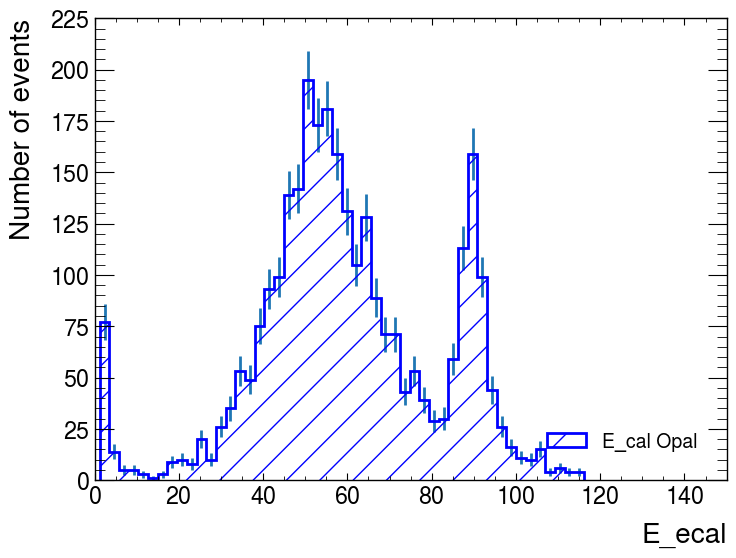

In [6]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
ratio = [1,4] # ratio of the two subplots

#Opal

bin_content_Opal, bin_edges_Opal, _ = plt.hist(data_Opal.loc[data_Opal['E_lep'] == 44.732]['E_ecal'],bins=50, histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='E_cal Opal')
mid_Opal = 0.5*(bin_edges_Opal[1:] + bin_edges_Opal[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content_Opal)

plt.errorbar(mid_Opal, bin_content_Opal, yerr=error_sizes, fmt='none')


#plt.ylim(0, 0.7*10**4)  # most of the data



### Show the plot on screen
plt.xlim(0,150)
plt.legend(loc = 4)
plt.xlabel('E_ecal')
plt.ylabel('Number of events')
plt.show()

First determine the number of events in the handronic channel *and* in the three leptonic channels


In [7]:
s_ratio= 0.470464817345979
sigma_ratio = 0.005072534012880613

In [237]:
def classify_event_in_4CH(Ncharged, Pcharged, E_ecal, E_hcal, cos_thet, I):
    if len(Ncharged)==len(Pcharged)==len(E_ecal)==len(E_hcal):
        #print(Ncharged)
        PI = np.chararray((len(Ncharged),1), itemsize=2)[:]
        PI[:] = 'NC'      # create start PI array with all events unclassified
        NC = 0      
        ee = 0      
        qq = 0
        mm = 0
        tt = 0
        print(f'Classification for Energy {meanenergy[I]}:\n')                 
        for i in range(len(Ncharged)):
            
            if (Ncharged[i] >= 7) & (E_ecal>20):
                PI[i] = "qq"
                qq += 1
            elif (E_ecal[i] >= 60) & (-0.9<cos_thet[i]<0.1):
                PI[i] = "ee"
                ee += 1 #* s_ratio
            elif (70<=Pcharged[i] <= 110):
                PI[i] = "mm"
                mm += 1
            elif (Pcharged[i] < 10) & (E_ecal[i] < 10):
                PI[i] = "mm"
                mm += 1
            elif (E_ecal[i] < 100) & (1 < Pcharged[i] < 75):
                PI[i] = "tt"
                tt += 1
            else:
                PI[i] = "NC"
                NC += 1

        #print(PI)
        print('ee, mm, tt, qq, NC,len(Ncharged)')
        print(ee, mm, tt, qq, NC,len(Ncharged))
        print()
    else:
        print('Unequaly long input arrays')
    return [[ee, mm, tt, qq, NC, len(Ncharged)], PI]

### Add particle ID

In [238]:
nchar = data_Opal['Ncharged'].to_numpy()
pchar = data_Opal['Pcharged'].to_numpy()
E_ecal = data_Opal['E_ecal'].to_numpy()
E_hcal = data_Opal['E_hcal'].to_numpy()
cos_thet = data_Opal['cos_thet'].to_numpy()
data_Opal.loc[:, ['ID']] = classify_event_in_4CH(nchar, pchar, E_ecal, E_hcal, cos_thet, i)[1]
#len(classify_event_in_4CH(nchar, pchar, E_ecal, E_hcal, i)[1])

Classification for Energy 91.2243:



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### create callification Matrix sorted by energies

In [239]:
classify_Opal = np.zeros((7,6))
for i in range(0,7,1):
    print(i)
    nchar = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['Ncharged'].to_numpy()
    pchar = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['Pcharged'].to_numpy()
    E_ecal = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['E_ecal'].to_numpy()
    E_hcal = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['E_hcal'].to_numpy()
    cos_thet = data_Opal.loc[data_Opal['COM_energy'] == meanenergy[i]]['cos_thet'].to_numpy()
    classify_Opal[i] = classify_event_in_4CH(nchar, pchar, E_ecal, E_hcal, cos_thet, i)[0]
classify_Opal_error = np.sqrt(classify_Opal)

0
Classification for Energy 88.47939:



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
classify_Opal_df = pd.DataFrame(dict(zip(['ee', 'mm', 'tt', 'qq', 'NC','length'], classify_Opal.transpose())))
classify_Opal_df['CMS_energies'] = meanenergy
classify_Opal_df = classify_Opal_df.join(pd.DataFrame(classify_Opal_error[:, :4], columns = ['ee_u', 'mm_u', 'tt_u', 'qq_u']))
classify_Opal_df

,ee,mm,tt,qq,NC,length,CMS_energies,ee_u,mm_u,tt_u,qq_u
0,122.0,94.0,476.0,2501.0,1200.0,4332.0,88.47939,11.045361,9.695360,21.817424,50.009999
1,338.0,290.0,828.0,6653.0,1807.0,9747.0,89.46793,18.384776,17.029386,28.774989,81.565924
2,408.0,402.0,803.0,8776.0,1322.0,11507.0,90.22266,20.199010,20.049938,28.337255,93.680307
3,2668.0,2955.0,4667.0,66937.0,6116.0,82009.0,91.22430,51.652686,54.359912,68.315445,258.721858
4,524.0,579.0,928.0,13010.0,1264.0,16043.0,91.96648,22.891046,24.062419,30.463092,114.061387
5,196.0,273.0,516.0,6264.0,914.0,8065.0,92.96465,14.000000,16.522712,22.715633,79.145436
6,252.0,296.0,676.0,6993.0,1350.0,9441.0,93.71712,15.874508,17.204651,26.000000,83.624159


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,
         0.,  2.,  0.,  0.,  0.,  2.,  2.,  2.,  6.,  9., 13.,  8.,  4.,
         2.,  1.,  4.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([61.062267, 61.803246, 62.54422 , 63.2852  , 64.02618 , 64.76715 ,
        65.508125, 66.24911 , 66.99008 , 67.73106 , 68.47204 , 69.21301 ,
        69.95399 , 70.69497 , 71.43594 , 72.17692 , 72.91789 , 73.658875,
        74.39985 , 75.14082 , 75.881805, 76.62278 , 77.363754, 78.10474 ,
        78.84571 , 79.586685, 80.32767 , 81.06864 , 81.809616, 82.55059 ,
        83.29157 , 84.03255 , 84.77352 , 85.5145  , 86.25548 , 86.99645 ,
        87.737434, 88.47841 , 89.21938 , 89.960365, 90.70134 , 91.442314,
        92.1833  , 92.92427 , 93.665245, 94.40622 , 95.1472  , 95.888176,
        96.62915 , 97.37013 , 98.11111 ], dtype=float32),
 <BarContainer object of 50 artists>)

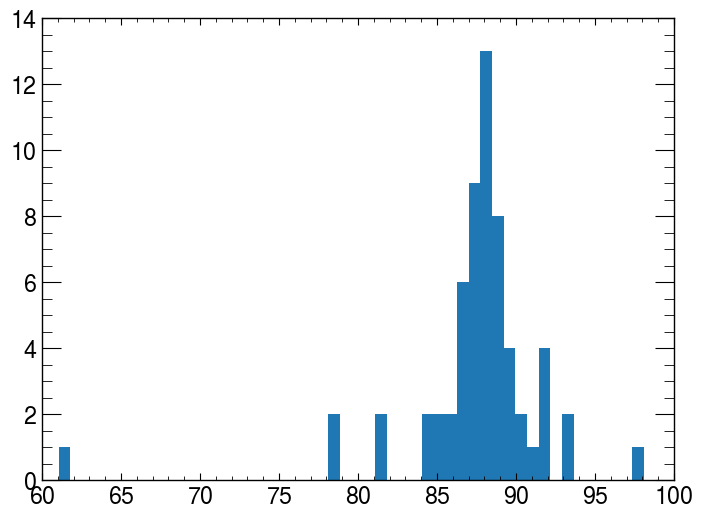

In [240]:
i = 0
plt.hist(data_Opal[(data_Opal['COM_energy'] == meanenergy[i]) & (data_Opal['ID'] == b'ee') & (data_Opal['cos_thet']<=0.25)]['E_ecal'].to_numpy(), bins = 50)

In [241]:
len(data_Opal[(data_Opal['ID'] == b'ee') & (data_Opal['cos_thet']>1)]['cos_thet'].to_numpy())

0

In [242]:
len(data_Opal[(data_Opal['ID'] == b'ee')]['cos_thet'].to_numpy())

2254

### Correct background and efficency 

* $N_{cut corr} = N_{cut} \epsilon^{-1}$

To get the error on the background and efficency corrected data one has to propagate the $\sqrt{N}$ error with the error of the inverse efficency matrix calculated using a toy MC and propagate it using gaussian error propagation.
* $\Delta N_{cut corr} = \sqrt{(\Delta N_{cut} \epsilon^{-1})^{2} + (N_{cut} \Delta \epsilon^{-1})^{2}}$

In [243]:
Matrix = np.array([[9.941e-01, 0.000e+00, 1.100e-03, 3.000e-04, 4.600e-03],
       [0.000e+00, 9.477e-01, 3.430e-02, 0.000e+00, 1.800e-02],
       [4.030e-02, 7.700e-03, 9.254e-01, 1.230e-02, 1.430e-02],
       [1.000e-03, 0.000e+00, 4.100e-03, 9.947e-01, 2.000e-04]])

Matrix_inv = np.linalg.inv(Matrix[:, :4])

Matrix_error_inv = np.array([[4.57926827e-03, 9.67518209e-07, 1.18074831e-04, 5.38185153e-05],
 [3.43399360e-05, 4.92972683e-03, 7.26840606e-04, 1.72674727e-04],
 [2.30087278e-04, 4.17500543e-05, 2.57312975e-04, 4.77883892e-03],
 [7.70717909e-04, 3.31387098e-04, 5.16922627e-03, 4.06636890e-04]])

In [244]:
Ncutcorr = np.zeros((7,4))
Ncutcorr_err = np.zeros((7,4))
Sigma = np.zeros((7,4))
Sigma_err = np.zeros((7,4))
for i in range(0,7,1):
    N_df = pd.DataFrame(classify_Opal_df.loc[classify_Opal_df['CMS_energies'] == meanenergy[i],['ee', 'mm', 'tt', 'qq']])
    N_err_df = pd.DataFrame(classify_Opal_df.loc[classify_Opal_df['CMS_energies'] == meanenergy[i],['ee_u', 'mm_u', 'tt_u', 'qq_u']])
    N = np.reshape(N_df.to_numpy(dtype=float),4)
    N_err = np.reshape(N_err_df.to_numpy(dtype=float),4)
    Ncor = N.dot(Matrix_inv)
    Nerrcor = np.sqrt( np.square( N.dot(Matrix_error_inv) )+ np.square( N_err.dot(Matrix_inv) ))
    Ncutcorr[i] = Ncor
    Ncutcorr_err[i] = Nerrcor
    sig = Ncor / lumi[i]
    sig_err = np.sqrt( np.square( Nerrcor / lumi[i]) + np.sqrt(Ncor / (lumi[i]**2) * all[i]) )
    Sigma[i] = sig
    Sigma_err[i] = sig_err


### Radiation corrections

In [245]:
hadronic = [2.0, 4.3, 7.7, 10.8, 4.7, -0.2, -1.6]
leptonic = [0.09, 0.20, 0.36, 0.52, 0.22, -0.01, -0.08]

In [246]:
for i in range(0,3,1):
    Sigma[:,i] = Sigma[:,i]+leptonic

Sigma[:,3] = Sigma[:,3]+hadronic

In [247]:
Ncutcorr

array([[   99.9470786 ,    95.12816628,   499.615171  ,  2508.11777347],
       [  298.67940522,   299.06757381,   853.72211673,  6677.80196455],
       [  368.60744565,   417.58114417,   812.77268457,  8812.59908892],
       [ 2428.57356588,  3080.47094285,  4628.27109897, 67235.6928656 ],
       [  476.58835193,   603.46181667,   921.97874576, 13067.77589718],
       [  169.79510183,   283.84898629,   519.00203789,  6290.90714427],
       [  218.55120249,   306.74715646,   687.75582152,  7021.68999501]])

In [248]:
Ncutcorr_err

array([[ 10.45753449,  10.12913054,  26.45992081,  50.09913121],
       [ 18.51725377,  18.10077359,  46.02372215,  81.90070855],
       [ 20.98122741,  21.4892061 ,  54.5229955 ,  94.1091971 ],
       [ 81.28991548,  67.74823829, 356.71459024, 264.02532619],
       [ 25.06841763,  26.14702591,  74.89844244, 114.69766231],
       [ 14.30172227,  17.58371507,  40.32018123,  79.43412197],
       [ 16.23902477,  18.33359804,  45.48042686,  83.95560418]])

In [249]:
Sigma_err

array([[0.21195801, 0.2093102 , 0.32025364, 0.48391036],
       [0.25007417, 0.25008596, 0.33042622, 0.55417992],
       [0.29172507, 0.30091897, 0.36899784, 0.66664347],
       [0.30038671, 0.3178968 , 0.38466743, 0.69404288],
       [0.30313967, 0.32143832, 0.37987128, 0.71800885],
       [0.2465963 , 0.28079196, 0.33550076, 0.62855839],
       [0.22801664, 0.24827857, 0.30888234, 0.5529238 ]])

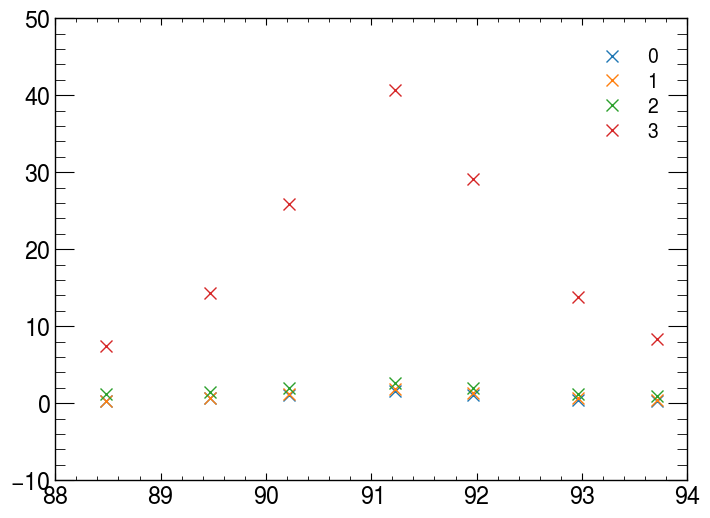

In [250]:
for i in range(0,4,1):
    plt.plot(meanenergy,Sigma[:,i], 'x', label=f'{i}')

plt.legend()

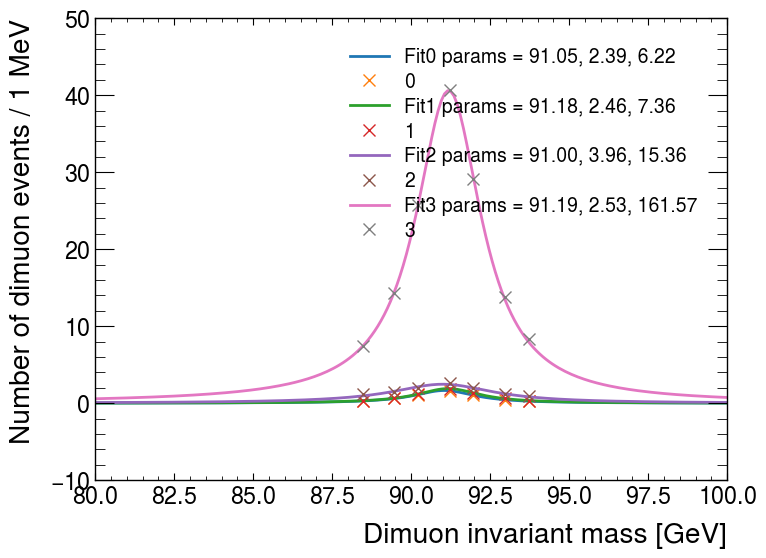

In [251]:
def relativistic_breit_wigner(x, resonance_mass, width, normalization):
    gamma = np.sqrt(resonance_mass ** 2 * (resonance_mass ** 2 + width ** 2))
    k = 2.0 * np.sqrt(2) * resonance_mass * width * gamma / (np.pi * np.sqrt(resonance_mass ** 2 + gamma))
    return normalization * k / ((x ** 2 - resonance_mass ** 2) ** 2 + resonance_mass ** 2 * width ** 2)

for i in range(0,4,1):
    popt, pcov = curve_fit(relativistic_breit_wigner, meanenergy,Sigma[:,i], p0=[90, 10, 30], maxfev = 8000)
    x = np.linspace(80, 100, 200)
    y = relativistic_breit_wigner(x, *popt)
    plt.plot(x, y, label=f'Fit{i} params = {popt[0]:.2f}, {popt[1]:.2f}, {popt[2]:.2f}')
    plt.plot(meanenergy,Sigma[:,i], 'x', label=f'{i}')
plt.xlabel('Dimuon invariant mass [GeV]')
plt.ylabel('Number of dimuon events / 1 MeV')
plt.legend()
plt.show()